<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

---

A common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. 

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialized topic.

In [26]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [79]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import AR, ARIMA, ARMA
from sklearn.metrics import mean_absolute_error

sns.set(font_scale = 1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# get the dataset
data = pd.read_csv('../../../../resource-datasets/walmart_stores/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Look back at the lesson notes for information about these models and acf/pacf plots

- [1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.](#filter)
- [2. Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?](#rolling)
- [3. Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.](#acf)
- [4. *BONUS:* What do the acf() and pacf() plots say about the type of model you want to build?](#interpretation)
- [5. Split the weekly sales data in a training and test set - using 75% of the data for training.](#train-test)
- [6. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)](#diff)
- [7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. How effective is this model?](#AR1)
- [8. Plot the residuals - where are their significant errors?](#residuals)
- [9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?](#AR2)
- [10. Assemble your findings including any useful graphs.](#summary)

<a id='filter'></a>
### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [4]:
# there are about 36 different stores in this dataset.
store1 = data[data['Store'] == 1]
store1.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [5]:
store1_sales = pd.DataFrame(store1['Weekly_Sales'].groupby(store1.index).sum())
store1_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [6]:
store1_sales.index = pd.to_datetime(store1_sales.index)
store1_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [13]:
store1_sales.shape

(143, 1)

<a id='rolling'></a>
### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

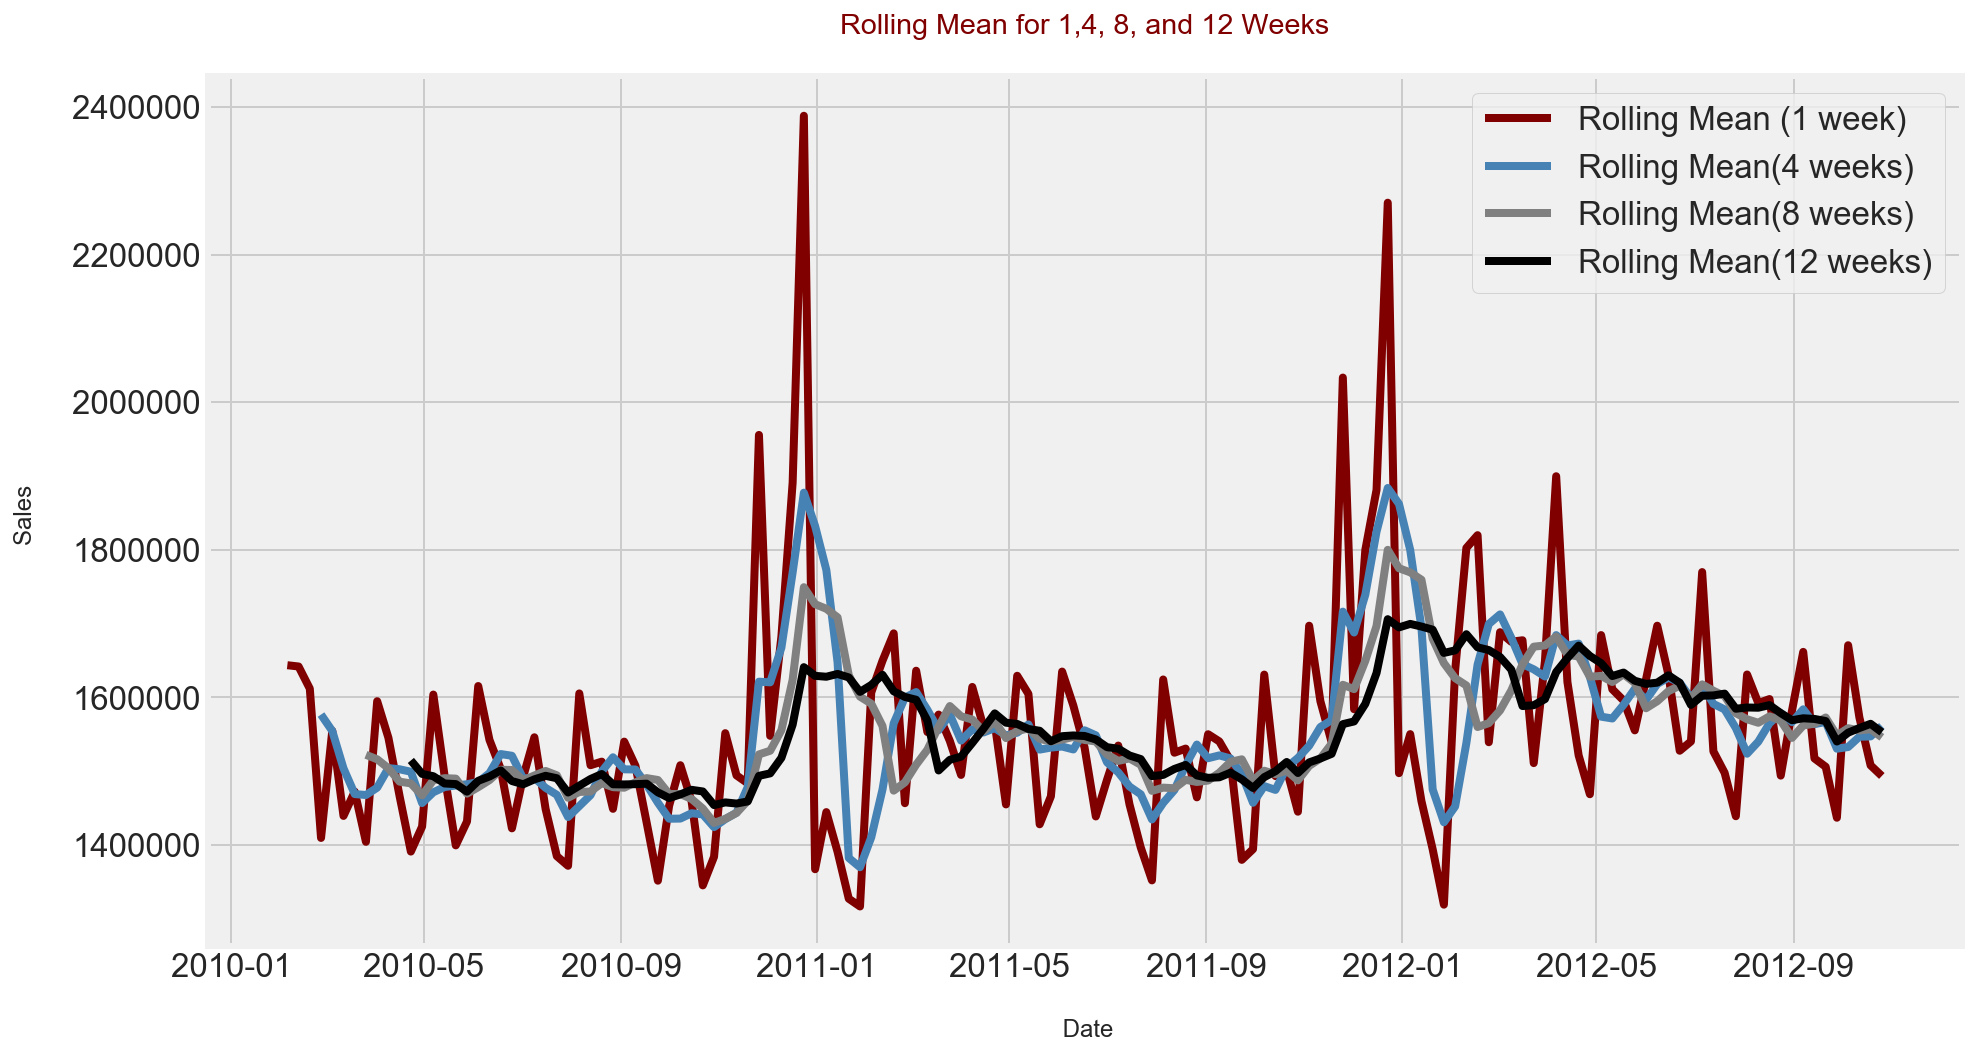

In [23]:
rolmean1  = store1_sales.rolling(window = 1).mean()
rolmean4  = store1_sales.rolling(window = 4).mean()
rolmean8 = store1_sales.rolling(window = 8).mean()
rolmean12 = store1_sales.rolling(window = 12).mean()

fig = plt.figure(figsize=(14, 8))
mean = plt.plot(rolmean1, color = 'maroon', label='Rolling Mean (1 week)')
mean = plt.plot(rolmean4, color = 'steelblue', label='Rolling Mean(4 weeks)')
mean = plt.plot(rolmean8, color = 'gray', label='Rolling Mean(8 weeks)')
mean = plt.plot(rolmean12, color = 'black', label='Rolling Mean(12 weeks)')

plt.legend()
plt.title('Rolling Mean for 1,4, 8, and 12 Weeks\n', color = 'maroon')
plt.xlabel('\n Date')
plt.ylabel('Sales \n')
plt.show()

<a id='acf'></a>
### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [28]:
print('1 Week Lag Auto-Correlation', store1_sales['Weekly_Sales'].autocorr(lag = 1))
print('2 Week Lag Auto-Correlation', store1_sales['Weekly_Sales'].autocorr(lag = 2))
print('52 Week Lag Auto-Correlation', store1_sales['Weekly_Sales'].autocorr(lag = 52))

1 Week Lag Auto-Correlation 0.3021582794113126
2 Week Lag Auto-Correlation 0.12741313055390097
52 Week Lag Auto-Correlation 0.8953760294777008


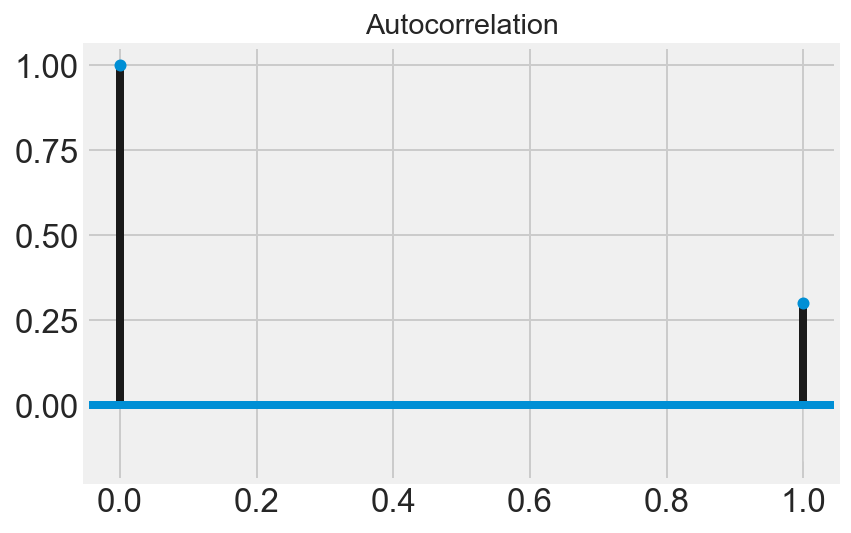

In [45]:
plot_acf(store1_sales, lags = 1);

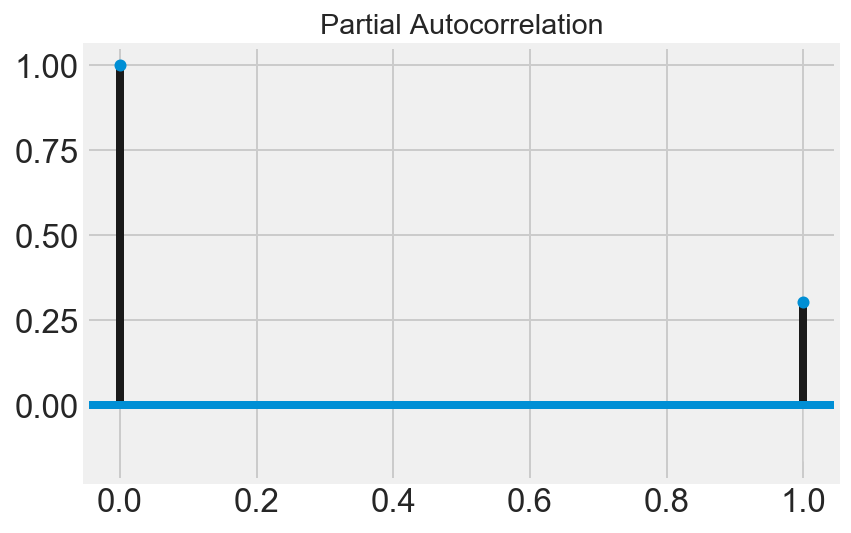

In [47]:
plot_pacf(store1_sales, lags = 1);

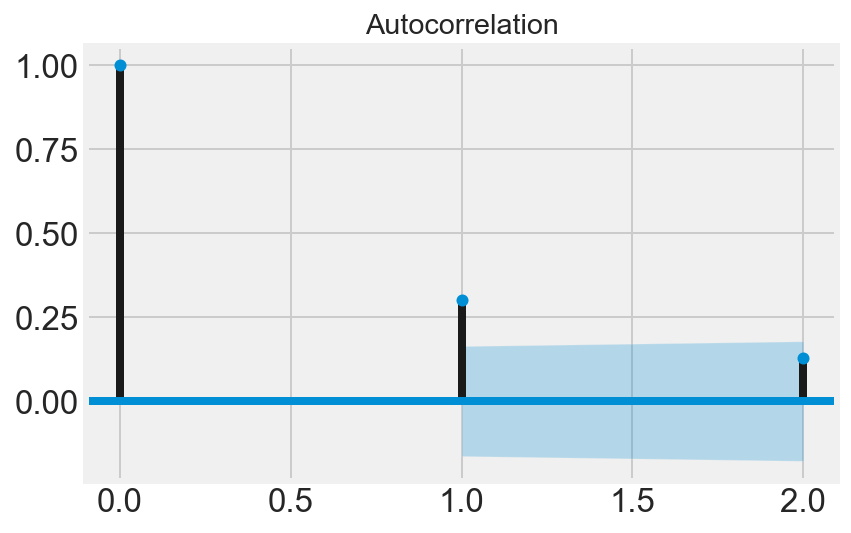

In [48]:
plot_acf(store1_sales, lags = 2);

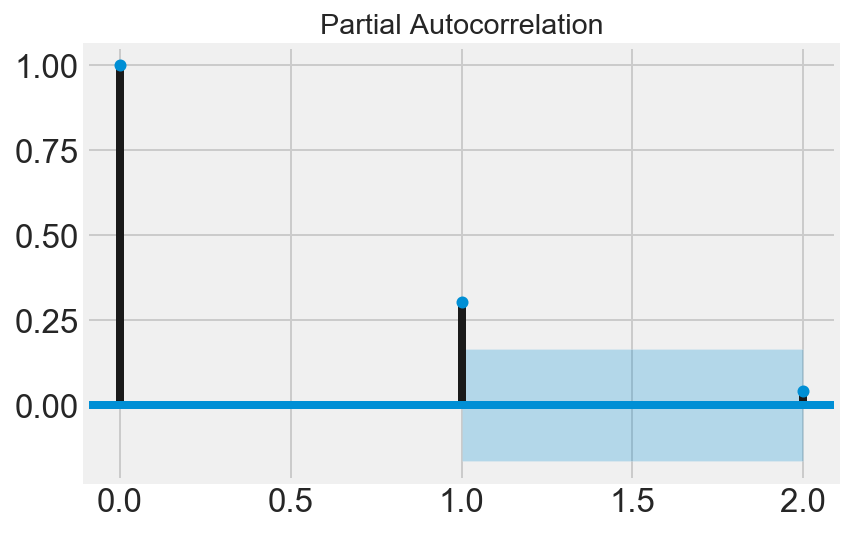

In [49]:
plot_pacf(store1_sales, lags = 2);

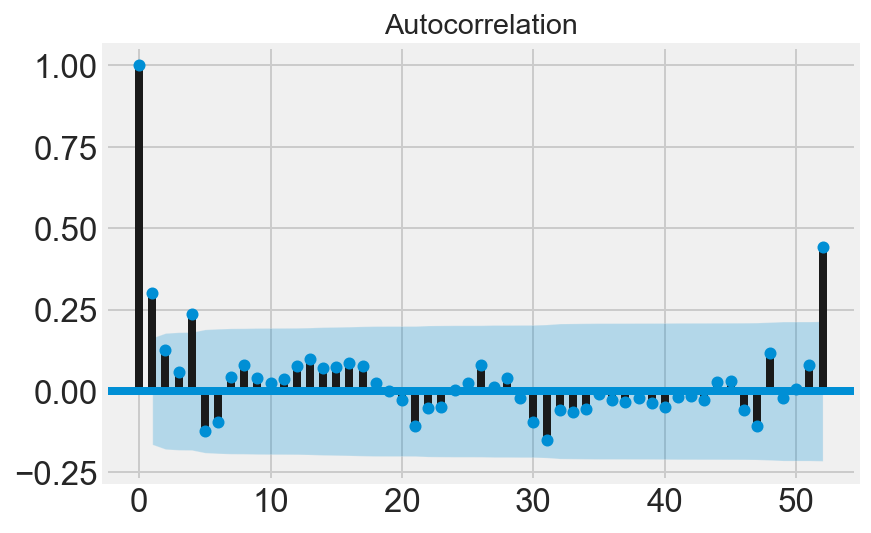

In [50]:
plot_acf(store1_sales, lags = 52);

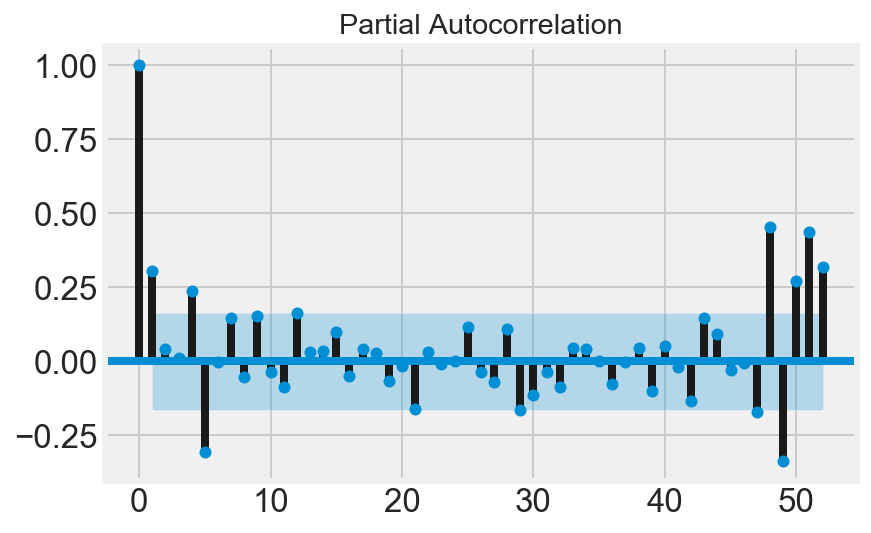

In [51]:
plot_pacf(store1_sales, lags = 52);

<a id='interpretation'></a>
### 4. BONUS: What do the acf and pacf plots say about the type of model you want to build?


<a id='train-test'></a>
### 5. Split the weekly sales data in a training and test set - using 75% of the data for training.

In [53]:
store1_sales.shape

(143, 1)

In [54]:
143 * 0.75

107.25

In [59]:
train = store1_sales.iloc[:107]
train.shape

(107, 1)

In [60]:
test = store1_sales.iloc[107:]
test.shape

(36, 1)

<a id='diff'></a>
### 6. "Difference" the data by converting the sales into change in sales 

In [62]:
store1_sales_difference = store1_sales['Weekly_Sales'].diff(periods = 1)
store1_sales_difference.head()

Date
2010-02-05          NaN
2010-02-12     -1733.46
2010-02-19    -29989.27
2010-02-26   -202240.58
2010-03-05    145079.09
Name: Weekly_Sales, dtype: float64

<a id='AR1'></a>
### 7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. 
####    How effective is this model?

In [64]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import mean_squared_error

In [65]:
train_values = train['Weekly_Sales'].values
train_indecies = train.index

AR1 = AR(train_values, train_indecies).fit()

C:\Users\HP-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [71]:
test.head()

,Weekly_Sales
Date,
2012-02-24,1539387.83
2012-03-02,1688420.76
2012-03-09,1675431.16
2012-03-16,1677472.78
2012-03-23,1511068.07


In [74]:
# checking the first date in the 'test' dataframe so we can specify the 'start' parameter later when we do predictions.
test.index[0]

Timestamp('2012-02-24 00:00:00')

In [76]:
# checking the last date in the 'test' dataframe so we can specify the 'end' parameter later when we do predictions.
test.index[35]

Timestamp('2012-10-26 00:00:00')

In [80]:
test_values = test['Weekly_Sales'].values

start_date = '2012-02-24' 
end_date   = '2012-10-26'

AR1_yhat = AR1.predict(start = start_date, end = end_date)

mean_absolute_error(test_values, AR1_yhat)

79376.32778110592

<a id='residuals'></a>
### 8. Plot the residuals - where are their significant errors?

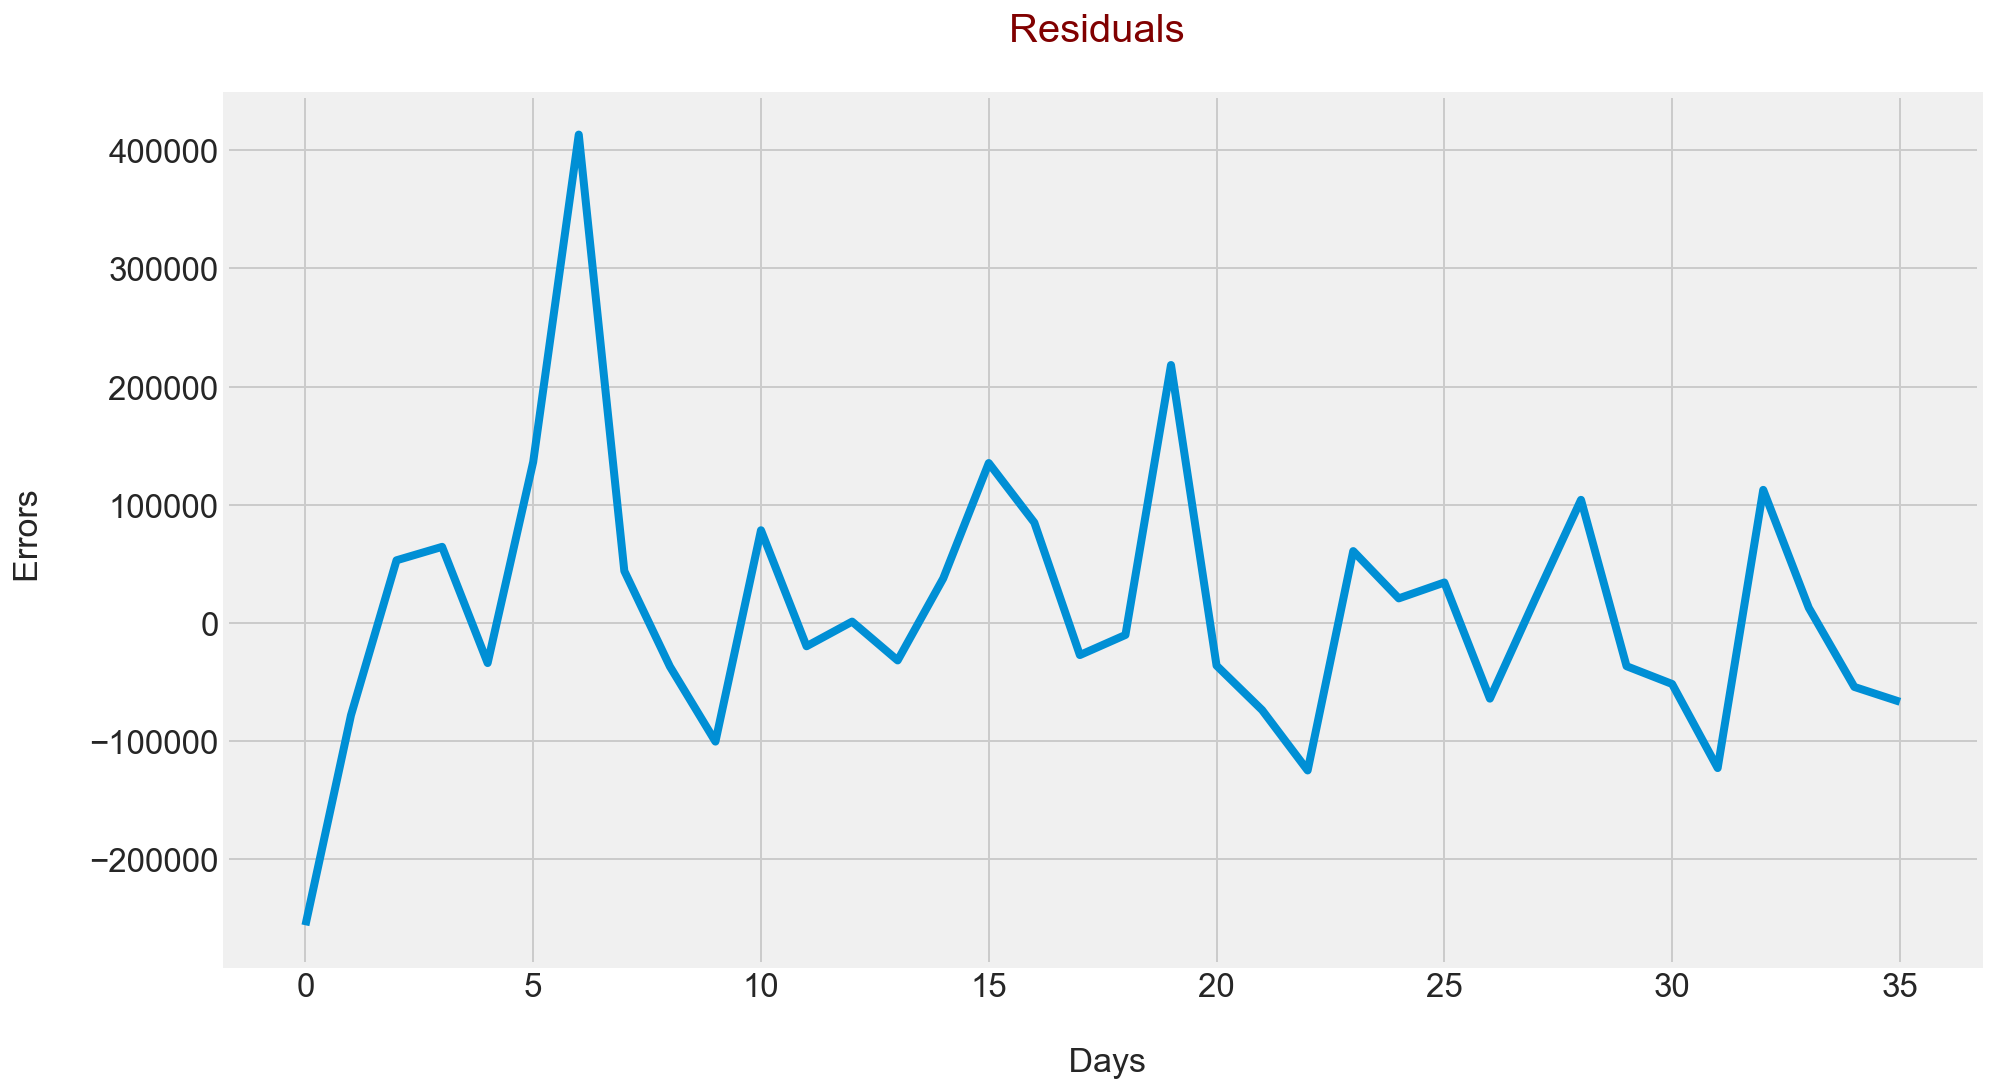

In [94]:
AR1_residuals = test_values - AR1_yhat

fig = plt.figure(figsize = (14, 8))
plt.plot(AR1_residuals)
plt.title('Residuals AR1 \n', size = 20, color = 'maroon')
plt.xlabel('\n Days', size = 17)
plt.ylabel('Errors \n', size = 17)
plt.show()

In [101]:
test_with_residuals = test.copy()
test_with_residuals['AR1_residual'] = AR1_residuals
test_with_residuals = test_with_residuals.reset_index()
test_with_residuals

,Date,Weekly_Sales,AR1_residuals
0,2012-02-24,1539387.83,-255840.277143
1,2012-03-02,1688420.76,-78074.969718
2,2012-03-09,1675431.16,53030.878063
3,2012-03-16,1677472.78,64408.942722
4,2012-03-23,1511068.07,-33924.539604
5,2012-03-30,1649604.63,136343.515763
6,2012-04-06,1899676.88,413314.124674
7,2012-04-13,1621031.70,43989.830189
8,2012-04-20,1521577.87,-36804.368043
9,2012-04-27,1468928.37,-100412.295061


It seems that day 6 (2012-04-06) has the highest residual, after that day 19 (2012-07-06), and then day 15 (2012-06-08).

<a id='AR2'></a>
### 9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?

In [103]:
AR2 = ARMA(endog = train_values, dates = train_indecies, order = (2,0)).fit()
AR2_yhat = AR2.predict(start = start_date, end = end_date)
mean_absolute_error(test_values, AR2_yhat)

C:\Users\HP-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


81203.23437315048

This mean squared error is worse than the original one.

In [105]:
AR22 = ARMA(endog = train_values, dates = train_indecies, order = (2,2)).fit()
AR22_yhat = AR22.predict(start = start_date, end = end_date)
mean_absolute_error(test_values, AR22_yhat)

C:\Users\HP-PC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


80502.43350697824

This mean squared error is also worse than the original one.

<a id='summary'></a>
### 10. Assemble your findings including any useful graphs.

In [109]:
AR2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Fri, 18 Jan 2019   AIC                           2876.963
Time:                        18:43:37   BIC                           2887.655
Sample:                    02-05-2010   HQIC                          2881.298
                         - 02-17-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06    2.4e+04     64.349      0.000     1.5e+06    1.59e+06
ar.L1.y        0.2974      0.097      3.075      0.003       0.108       0.487
ar.L2.y        0.0589      0.098      0.603      0.548      -0.132       0.250
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3080           +0.0000j            2.3080            0.0000
AR.2           -7.3587           +0.0000j            7.3587            0.5000
-----------------------------------------------------------------------------
"""

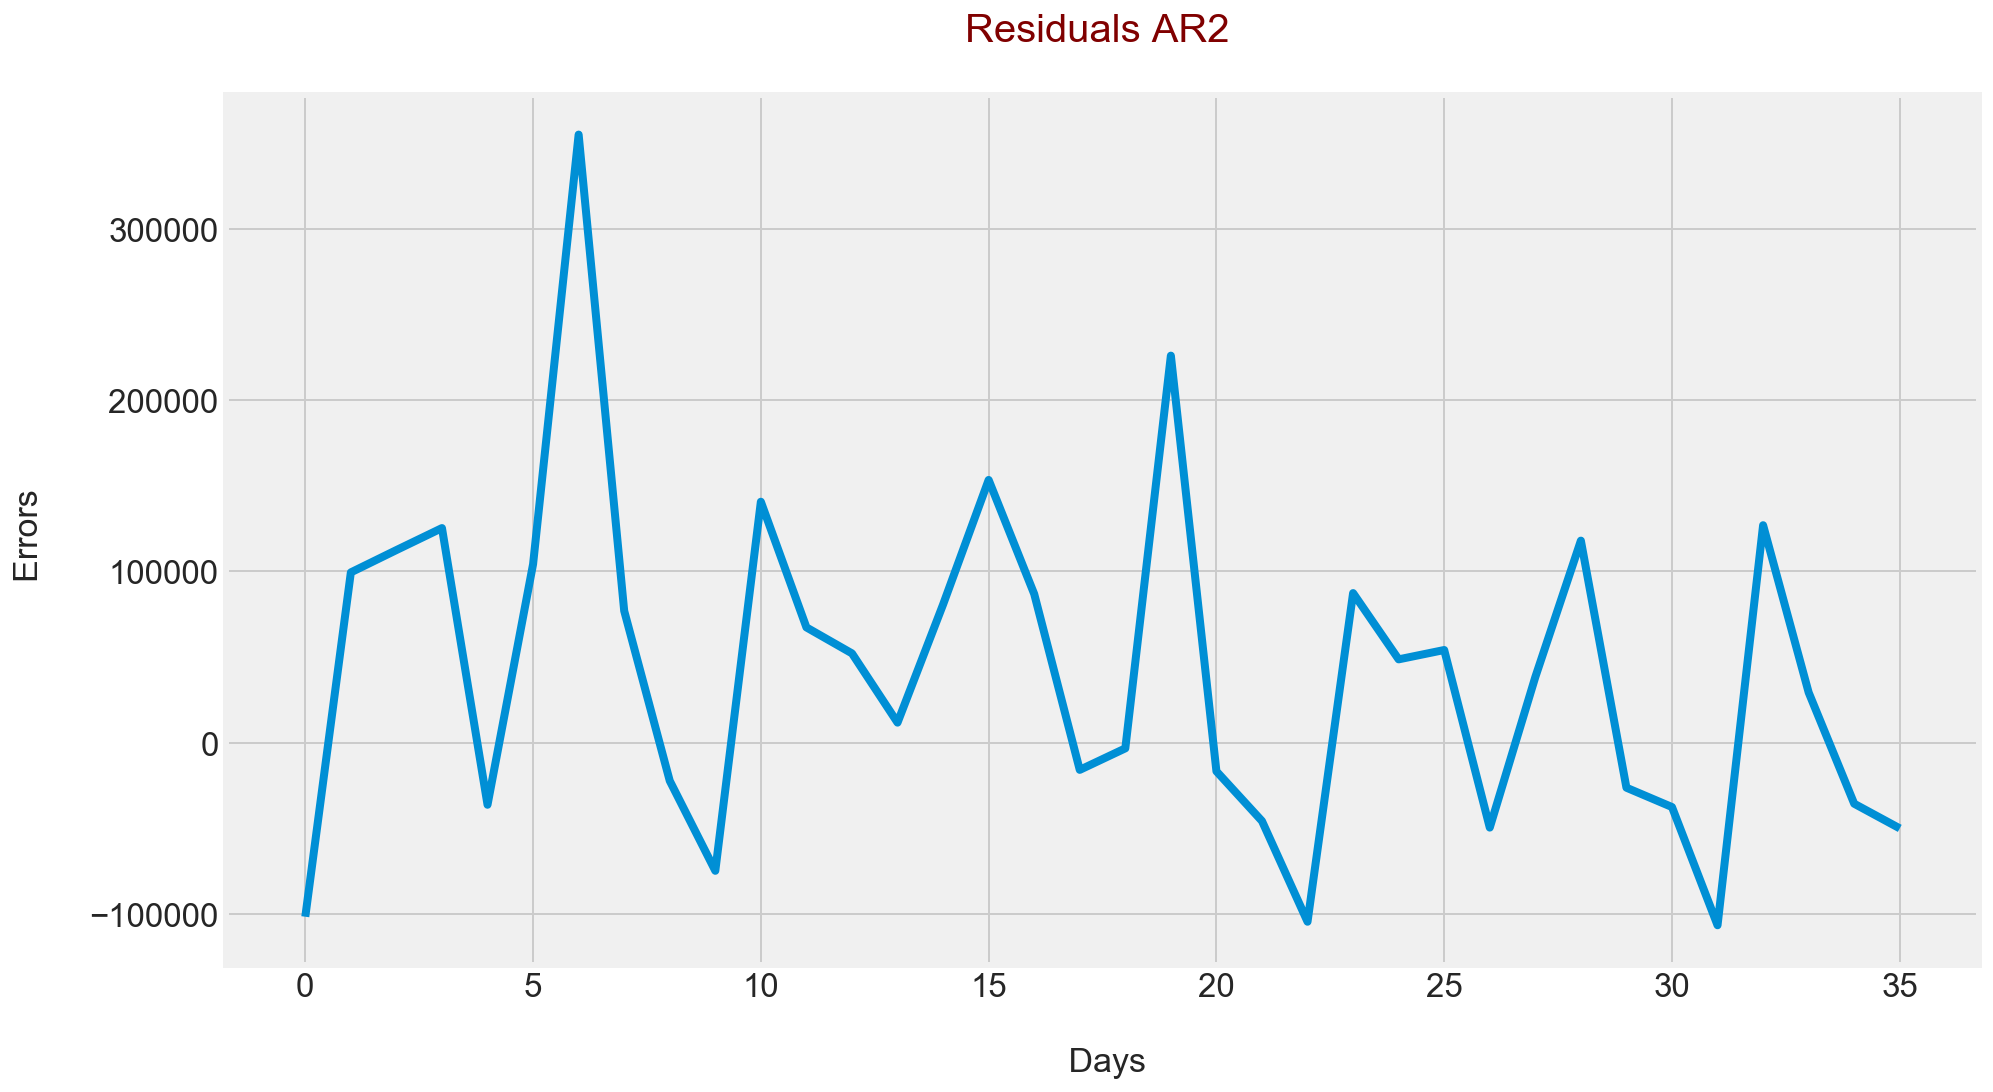

In [111]:
AR2_residuals = test_values - AR2_yhat

fig = plt.figure(figsize = (14, 8))
plt.plot(AR2_residuals)
plt.title('Residuals AR2 \n', size = 20, color = 'maroon')
plt.xlabel('\n Days', size = 17)
plt.ylabel('Errors \n', size = 17)
plt.show()

In [113]:
AR22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144115.551
Date:                Fri, 18 Jan 2019   AIC                           2863.563
Time:                        18:45:29   BIC                           2879.600
Sample:                    02-05-2010   HQIC                          2870.064
                         - 02-17-2012                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   1.92e+04     80.320      0.000    1.51e+06    1.58e+06
ar.L1.y       -1.0398      0.090    -11.583      0.000      -1.216      -0.864
ar.L2.y       -0.4701      0.087     -5.380      0.000      -0.641      -0.299
ma.L1.y        1.4691      0.058     25.346      0.000       1.356       1.583
ma.L2.y        0.9997      0.074     13.533      0.000       0.855       1.145
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

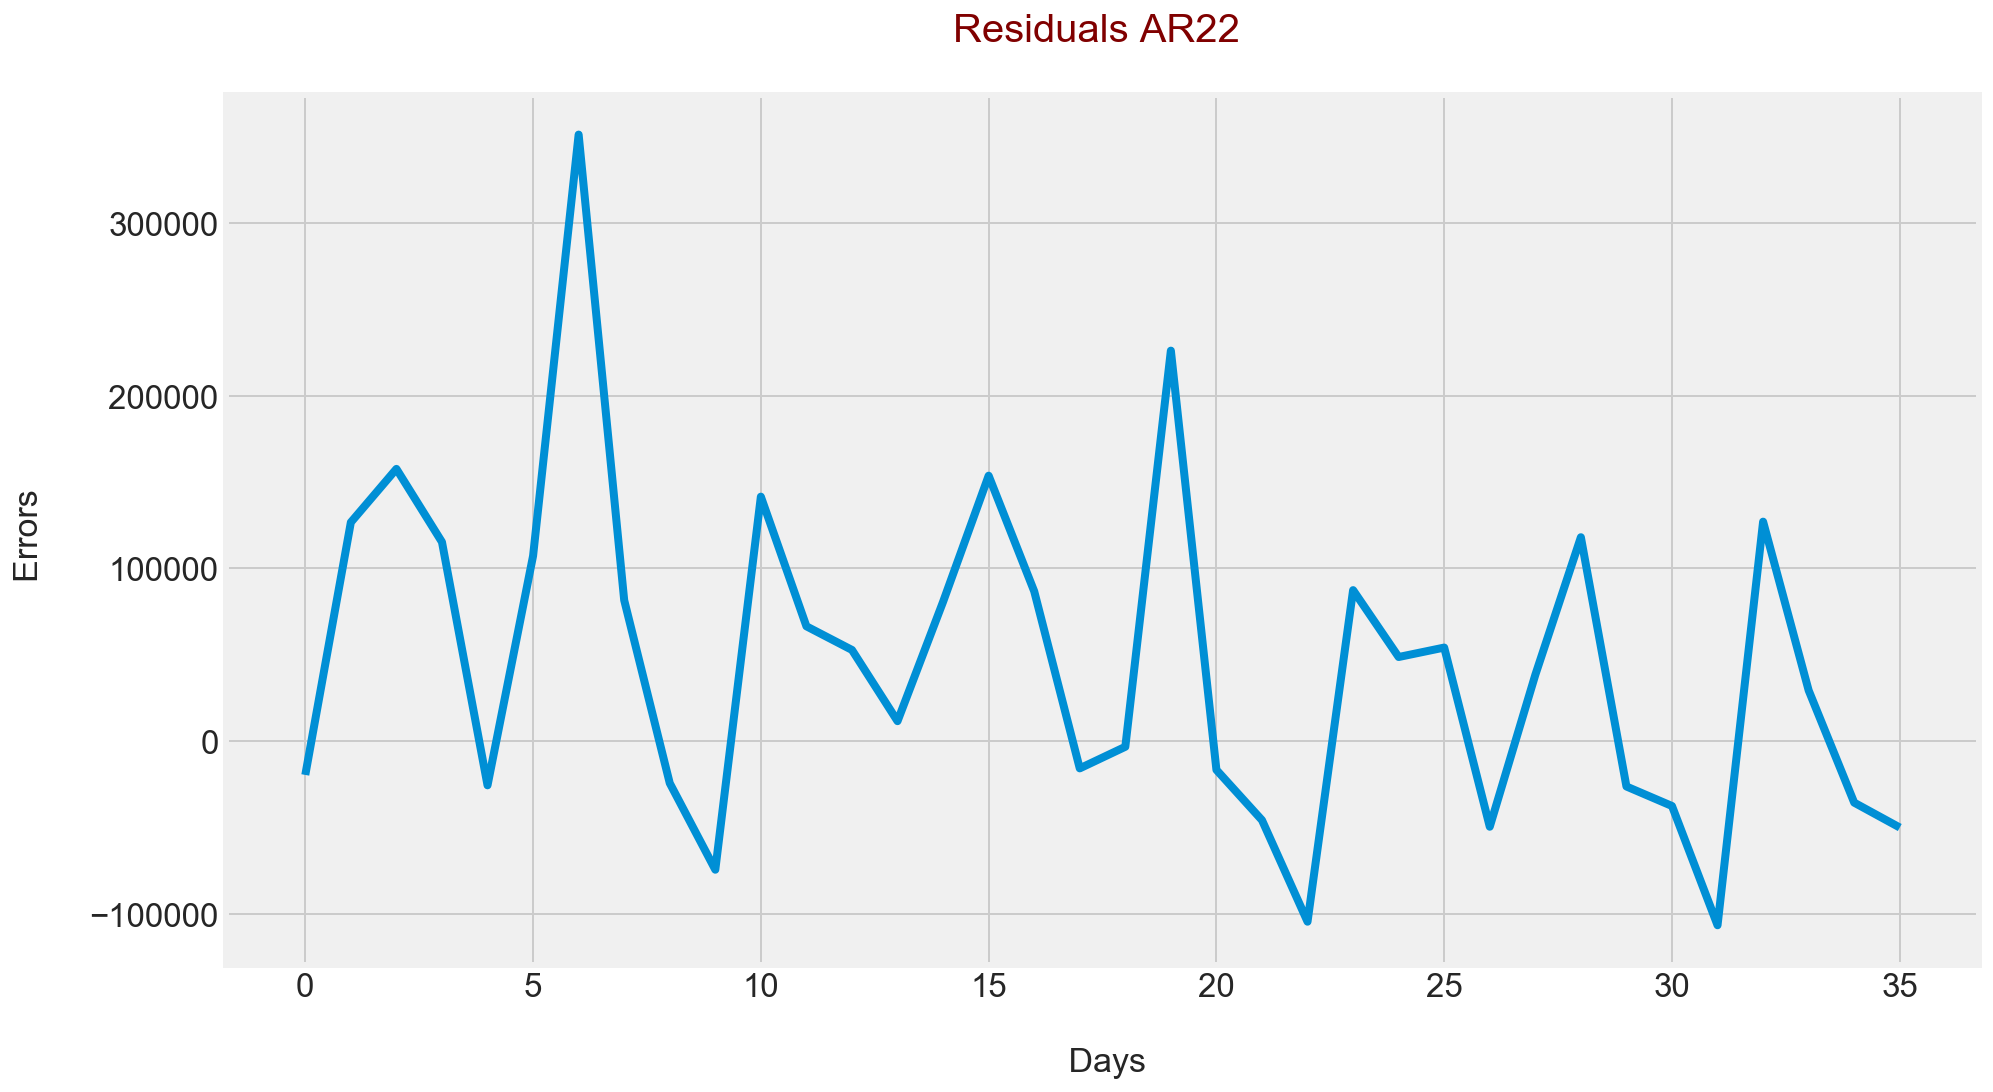

In [114]:
AR22_residuals = test_values - AR22_yhat

fig = plt.figure(figsize = (14, 8))
plt.plot(AR22_residuals)
plt.title('Residuals AR22 \n', size = 20, color = 'maroon')
plt.xlabel('\n Days', size = 17)
plt.ylabel('Errors \n', size = 17)
plt.show()